## Credit Curve Bootstrapper

The goal of the project is to build a bootstrapping procedure whose output will be a credit curve (an instance of the Python class CreditCurve). The input parameters to derive this curve are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotations);
* the par rate of a set of Credit Default Swap (i.e. their market quotations).

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for evaluation of risky flows.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
from datetime import date
import pandas as pd

pricing_date = date(2019, 10, 31)
cds_recovery = 0.4

ois_quotes = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.csv")
cds_quotes = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/cds_quotes_proj2.csv")
cds_to_price = pd.read_csv('https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/cds_to_price_proj2.csv')

In [ ]:
from finmarkets import OvernightIndexSwap

pillar_dates = [pricing_date]

swaps = []

for q in range(len(ois_quotes)):
    swap = OvernightIndexSwap(1, pricing_date,
                              ois_quotes.loc[q, 'quote']*0.01,
                              ois_quotes.loc[q, 'months'])
    
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])


In [ ]:
from finmarkets import DiscountCurve

def objective_function(x):
    curve = DiscountCurve(pillar_dates, x)
    
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq

In [ ]:
from scipy.optimize import minimize

x0 = [.51 for i in range(len(pillar_dates))]
bounds = [(0.01, 10.0) for i in range(len(pillar_dates))]
bounds[0] = (1, 1)

result = minimize(objective_function, x0, bounds=bounds)

In [ ]:
print (result.x)
print (objective_function(x0))
print (objective_function(result.x))

[1.         1.00040399 1.00082111 1.00123969 1.00162942 1.00204561
 1.00244424 1.00285343 1.00324509 1.00364368 1.00403373 1.00440408
 1.00467299 1.00678563 1.00895251 1.01024584 1.01070549 1.00993101
 1.00775587 1.00433842 0.9997303  0.99391153 0.98726976 0.98007544
 0.97221834 0.94694649 0.91134836 0.88803028 0.87557081 0.86625742
 0.85942385 0.85104143]
0.02973228244957498
4.718982840159733e-15


In [ ]:
discount_curve = DiscountCurve(pillar_dates, result.x)

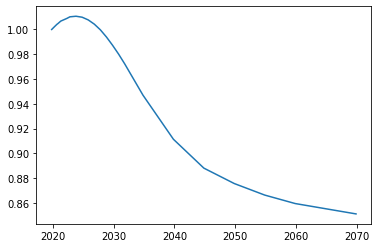

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pillar_dates, result.x)
plt.show()

In [ ]:
from finmarkets import CreditDefaultSwap, CreditCurve

cds_pillar_dates = [pricing_date]

creditdefaultswaps = []
for q in range(len(cds_quotes)):
    creditdefswap = CreditDefaultSwap(1, pricing_date,
                                      cds_quotes.loc[q, 'maturity']//12, 
                                      cds_quotes.loc[q, 'spread'])
    
    creditdefaultswaps.append(creditdefswap)
    cds_pillar_dates.append(creditdefswap.payment_dates[-1])

In [ ]:
def obj_function(unknown_ndps):
    curve_c = CreditCurve(cds_pillar_dates, unknown_ndps)
    sum_sq = 0.0

    for creditdefswap in creditdefaultswaps:
        sum_sq += creditdefswap.npv(discount_curve, curve_c) ** 2

    return sum_sq

In [ ]:
x0_guess = [0.5 for i in range(len(cds_pillar_dates))]
bounds_credit_curve = [(0.01, 1) for i in range(len(cds_pillar_dates))]
bounds_credit_curve[0] = (1, 1)

results = minimize(obj_function, x0_guess, bounds=bounds_credit_curve)

In [ ]:
print (results)
print (obj_function(x0_guess))
print (obj_function(results.x))

      fun: 8.631175588753267e-12
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.83820862e-07, -8.86429508e-07, -1.38792453e-06,  1.94413148e-06,
        2.18908415e-06, -1.56854694e-06, -1.25463046e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 112
      nit: 12
   status: 0
  success: True
        x: array([1.        , 0.90676341, 0.8041105 , 0.70882342, 0.5448831 ,
       0.26981433, 0.05110553])
0.8340908689179107
8.631175588753267e-12


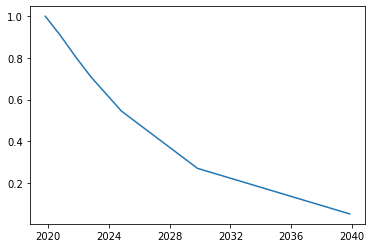

In [ ]:
plt.plot(cds_pillar_dates, results.x)
plt.show()

In [ ]:
credit_curve = CreditCurve(cds_pillar_dates, results.x)

In [ ]:
npv_cds_to_price = []

for q in range(len(cds_to_price)):
    creditdefswapprice = CreditDefaultSwap(cds_to_price.loc[q, 'nominal'],
                                           pricing_date,
                                           cds_to_price.loc[q, 'maturity'],
                                           cds_to_price.loc[q, 'spread'])
    
    npv_cds_to_price.append(creditdefswapprice.npv(discount_curve, credit_curve))

print ("Prices of CDS " + str(["{:.2f}".format(p) for p in npv_cds_to_price]))

Prices of CDS ['8728.63', '-264693.43', '811571.52', '458355.10', '-1923950.23', '-561693.44', '-219211.14', '-1070638.47', '704704.91', '-251105.44', '-729413.03', '-2183016.55', '-4569576.59', '-7889093.16', '-12402523.80']
